<a href="https://colab.research.google.com/github/sunknight611/Colab/blob/main/Lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release 

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-ctq3_e0x
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-ctq3_e0x
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
  Created wheel for d2l: filename=d2l-2.0.0a2-py3-none-any.whl size=64318 sha256=7f21237b981897babe16c65a3f22e890c336936d6619aaeccc7b94ea4a0399d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ztf5fvux/wheels/73/f4/42/d2b85ca46d85a241d6aa57c1c24027de2d2258202bb67945f9
Successfully built d2l


卷积之后的维度为
N = (W - F + 2P) / S + 1
N:output_shape为N * N
W:input_shape为W * W
F：Filter大小为F * F
P：padding大小
S:步长stride

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
  def forward(self,x):
    return x.view(-1,1,28,28)
  
net = torch.nn.Sequential(
      Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),###28 * 28
      nn.AvgPool2d(2,stride=2),                   ###14 * 14
      nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),          ###10 * 10
      nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),      ###5 * 5
      nn.Linear(16*5*5,120),nn.Sigmoid(),              
      nn.Linear(120,84),nn.Sigmoid(),
      nn.Linear(84,10)
  )

In [ ]:
X = torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t',X.shape)

Reshape output shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
batch_size=256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net,train_iter,trst_iter,num_epochs,lr,device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  print('training on',device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(),lr = lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=['train loss','train acc','test acc'])
  timer,num_batches = d2l.Timer(),len(train_iter)
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i,(X,y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X,y = X.to(device),y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      l.backward()
      optimizer.step()
      metric.add(l * X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
         animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net,test_iter)
    animator.add(epoch + 1,(None,None,test_acc))
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.479, train acc 0.820, test acc 0.690
21990.0 examples/sec on cuda:0


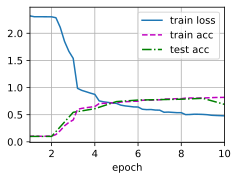

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())